# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE GeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_egemaps_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_best_overall_opensmile_egemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_egemaps_features = df_essentia_best_overall_opensmile_egemaps_features[df_essentia_best_overall_opensmile_egemaps_features.columns[1:]]

df_essentia_best_overall_opensmile_egemaps_features

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,2,0.023745,0.224209,0.054855,0.392382,0.631265,0.625832,0.593381,0.579839,0.267674,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,3,0.082083,0.348482,0.211289,0.402792,0.543954,0.677312,0.677951,0.907102,0.118704,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,4,0.018062,0.213582,0.084731,0.661722,0.554446,0.593904,0.570916,0.686407,0.209877,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,5,0.016018,0.181322,0.041096,0.651524,0.395875,0.900862,0.900318,0.274781,0.429967,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,7,0.107675,0.349349,0.197274,0.181959,0.602087,0.450784,0.432106,0.938413,0.080032,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.013781,0.186248,0.077709,0.476088,0.626271,0.772039,0.770549,0.239129,0.649168,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,1997,0.012825,0.189153,0.073405,0.471430,0.576407,0.551288,0.577018,0.631457,0.278428,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,1998,0.016787,0.199106,0.055710,0.467379,0.654543,0.722595,0.743935,0.634282,0.178965,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,1999,0.022245,0.224935,0.054033,0.255286,0.625434,0.669501,0.701341,0.558181,0.293156,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [4]:
df_essentia_best_overall_opensmile_egemaps_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 126 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    song_id                                         int64  
 1    lowlevel.melbands_kurtosis.mean                 float64
 2    lowlevel.melbands_skewness.mean                 float64
 3    lowlevel.spectral_energy.mean                   float64
 4    tonal.chords_strength.mean                      float64
 5    tonal.hpcp_entropy.mean                         float64
 6    tonal.key_edma.strength                         float64
 7    tonal.key_temperley.strength                    float64
 8    rhythm.beats_loudness_band_ratio.mean_0         float64
 9    rhythm.beats_loudness_band_ratio.mean_1         float64
 10   rhythm.beats_loudness_band_ratio.mean_2         float64
 11   rhythm.beats_loudness_band_ratio.mean_3         float64
 12   rhythm.beats_loudn

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_egemaps_whole = pd.merge(df_essentia_best_overall_opensmile_egemaps_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_egemaps_whole = df_essentia_best_overall_opensmile_egemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_egemaps_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,valence_mean_mapped,arousal_mean_mapped
0,0.023745,0.224209,0.054855,0.392382,0.631265,0.625832,0.593381,0.579839,0.267674,0.163056,...,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429,-0.475,-0.500
1,0.082083,0.348482,0.211289,0.402792,0.543954,0.677312,0.677951,0.907102,0.118704,0.015192,...,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348,-0.375,-0.425
2,0.018062,0.213582,0.084731,0.661722,0.554446,0.593904,0.570916,0.686407,0.209877,0.085901,...,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370,0.175,0.125
3,0.016018,0.181322,0.041096,0.651524,0.395875,0.900862,0.900318,0.274781,0.429967,0.346099,...,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132,-0.150,0.075
4,0.107675,0.349349,0.197274,0.181959,0.602087,0.450784,0.432106,0.938413,0.080032,0.025854,...,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.013781,0.186248,0.077709,0.476088,0.626271,0.772039,0.770549,0.239129,0.649168,0.208802,...,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006,-0.275,0.225
1740,0.012825,0.189153,0.073405,0.471430,0.576407,0.551288,0.577018,0.631457,0.278428,0.138446,...,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482,0.075,-0.275
1741,0.016787,0.199106,0.055710,0.467379,0.654543,0.722595,0.743935,0.634282,0.178965,0.163915,...,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258,0.350,0.300
1742,0.022245,0.224935,0.054033,0.255286,0.625434,0.669501,0.701341,0.558181,0.293156,0.168323,...,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_egemaps_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0.023745,0.224209,0.054855,0.392382,0.631265,0.625832,0.593381,0.579839,0.267674,0.163056,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,0.082083,0.348482,0.211289,0.402792,0.543954,0.677312,0.677951,0.907102,0.118704,0.015192,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,0.018062,0.213582,0.084731,0.661722,0.554446,0.593904,0.570916,0.686407,0.209877,0.085901,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,0.016018,0.181322,0.041096,0.651524,0.395875,0.900862,0.900318,0.274781,0.429967,0.346099,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,0.107675,0.349349,0.197274,0.181959,0.602087,0.450784,0.432106,0.938413,0.080032,0.025854,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.013781,0.186248,0.077709,0.476088,0.626271,0.772039,0.770549,0.239129,0.649168,0.208802,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,0.012825,0.189153,0.073405,0.471430,0.576407,0.551288,0.577018,0.631457,0.278428,0.138446,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,0.016787,0.199106,0.055710,0.467379,0.654543,0.722595,0.743935,0.634282,0.178965,0.163915,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,0.022245,0.224935,0.054033,0.255286,0.625434,0.669501,0.701341,0.558181,0.293156,0.168323,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [35]:
num_epochs = 296

Set a random seed to ensure consistent initial weights of the neural network

In [36]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [38]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 125])


Training loop

In [39]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [40]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5991991858042647
Epoch 2, Loss: 0.5966609321306235
Epoch 3, Loss: 0.5943576062903521
Epoch 4, Loss: 0.5921069550908326
Epoch 5, Loss: 0.5899421407729427
Epoch 6, Loss: 0.5878938693847353
Epoch 7, Loss: 0.5858989448578229
Epoch 8, Loss: 0.5839581180653315
Epoch 9, Loss: 0.5820718533479088
Epoch 10, Loss: 0.5802395785380765
Epoch 11, Loss: 0.5786246898186331
Epoch 12, Loss: 0.5770632040275048
Epoch 13, Loss: 0.5755399180106132
Epoch 14, Loss: 0.5740291256410236
Epoch 15, Loss: 0.572549690855331
Epoch 16, Loss: 0.5711165208360346
Epoch 17, Loss: 0.5697358756731247
Epoch 18, Loss: 0.5684029211816883
Epoch 19, Loss: 0.5671189132710206
Epoch 20, Loss: 0.5658884509783968
Epoch 21, Loss: 0.5647174783759582
Epoch 22, Loss: 0.5636406036606214
Epoch 23, Loss: 0.5626259238967141
Epoch 24, Loss: 0.561677039326087
Epoch 25, Loss: 0.5609216533749605
Epoch 26, Loss: 0.5602269605540412
Epoch 27, Loss: 0.5595878611637328
Epoch 28, Loss: 0.5590062785572271
Epoch 29, Loss: 0.5584797776265

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [41]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 125])


Generating scores

In [42]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [43]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.21280780790483012
Valence RMSE: 0.19553548974972054
Arousal RMSE: 0.22877980343302834
Test R^2 score: tensor([0.5366, 0.4817], dtype=torch.float64)
Test Adjusted R^2 score: tensor([0.2769, 0.1912], dtype=torch.float64)
Test R^2 score (overall): 0.5091924284113967


In [44]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_overall_opensmile_egemaps_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [23]:
test_pred

tensor([[ 0.0910,  0.0978],
        [-0.2725, -0.3204],
        [ 0.3787,  0.2426],
        [ 0.1949,  0.2136],
        [-0.0218, -0.0362],
        [-0.2851, -0.3343],
        [-0.3686, -0.4257],
        [ 0.3116,  0.2621],
        [-0.3329, -0.3868],
        [ 0.2488,  0.2475],
        [ 0.1044,  0.1133],
        [-0.2239, -0.2665],
        [-0.2748, -0.3223],
        [ 0.1867,  0.2076],
        [-0.1053, -0.1345],
        [-0.0277, -0.0432],
        [-0.3704, -0.4278],
        [-0.1072, -0.1376],
        [ 0.1438,  0.1568],
        [-0.3127, -0.3649],
        [-0.3552, -0.4116],
        [-0.1661, -0.2023],
        [-0.4275, -0.4911],
        [ 0.1547,  0.1707],
        [ 0.0897,  0.0959],
        [-0.0469, -0.0663],
        [ 0.3122,  0.2623],
        [ 0.1431,  0.1558],
        [ 0.1210,  0.1314],
        [ 0.2783,  0.2590],
        [-0.3875, -0.4466],
        [-0.0405, -0.0585],
        [ 0.1468,  0.1606],
        [-0.0185, -0.0318],
        [-0.3069, -0.3579],
        [-0.1114, -0

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [24]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [25]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5991991858042647
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3531116705331126
Valence RMSE: 0.3606248017924741
Arousal RMSE: 0.34543516912079136
Test R^2 score: tensor([-0.5761, -0.1815], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-1.4595, -0.8438], dtype=torch.float64)
Test R^2 score (overall): -0.3788004634240414
Num of epochs: 2
Epoch 1, Loss: 0.5991991858042647
Epoch 2, Loss: 0.5966609321306235
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3503328045989162
Valence RMSE: 0.35738452557476424
Arousal RMSE: 0.3431361957532103
Test R^2 score: tensor([-0.5479, -0.1658], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-1.4155, -0.8194], dtype=torch.float64)
Test R^2 score (overall): -0.3568655315431488
Num of epochs: 3
Epoch 1, Loss: 0.5991991858042647
Epoch 2, Loss: 0.5966609321306235
Epoch 3, Loss: 0.5943576062903521
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3

### Plot graphs to visualise relationship between the evaluation metrics

Import relevant libraries

In [26]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

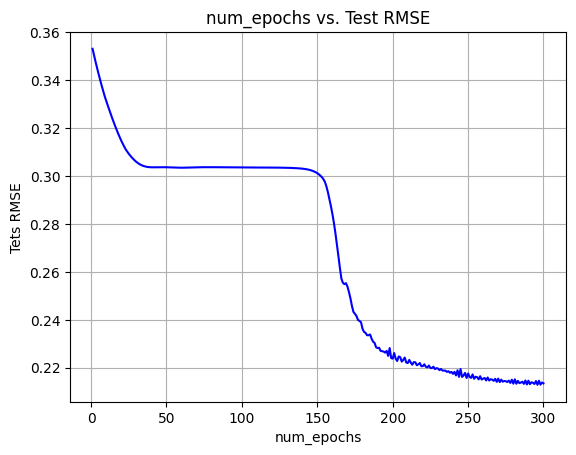

In [27]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [28]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.21280780790483012
Corresponding R^2 SCore: 0.5091924284113967
Corresponding num_epochs: 296


#### Test R^2 Score vs. num_epochs

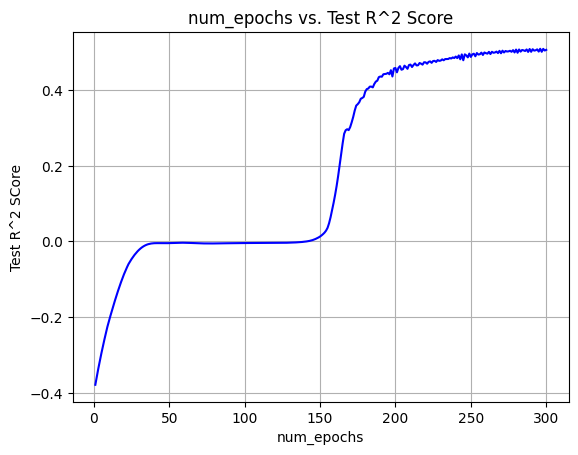

In [29]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [30]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5091924284113967
Corresponding RMSE: 0.21280780790483012
Corresponding num_epochs: 296


#### Test Adjusted R^2 Score (Valence) vs. num_epochs

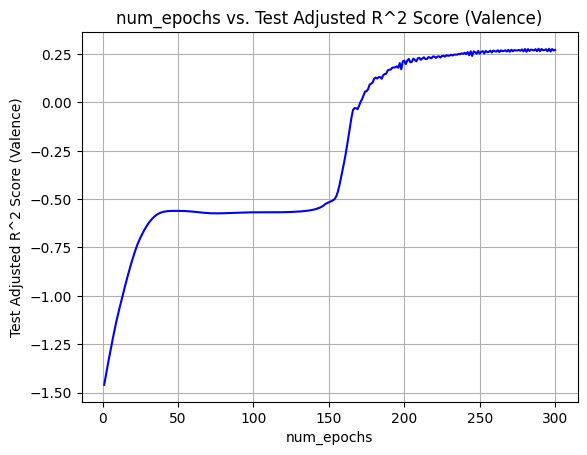

In [31]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [32]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.2770349690971621
Corresponding RMSE: 0.2129501037454648
Corresponding num_epochs: 289


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

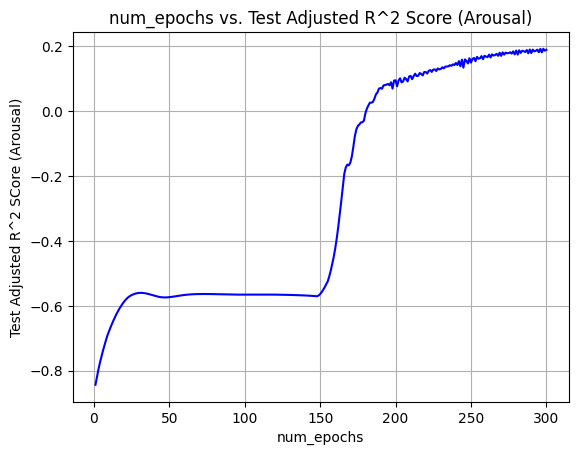

In [33]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [34]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.19144835740178634
Corresponding RMSE: 0.21285975084657627
Corresponding num_epochs: 298
